In [208]:
# !pip install wrds

import pandas as pd
import numpy as np
import wrds
import math
import matplotlib.pyplot as plt
from pandas import DatetimeIndex

In [222]:
db = wrds.Connection()

Enter your WRDS username [Hatricano]:rkarthick1997
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


In [217]:
# db.list_libraries()
# db.list_tables(library='crsp')

In [124]:
# monthly_returns - returns
# mnav - monthly totalnetasset

monthly_return_nav = db.raw_sql("""

select a.*, b.caldt, b.mret monthly_return, c.mnav monthly_nav  from (
select distinct crsp_fundno, fund_name, lipper_class_name
from crsp.fund_summary2
where lipper_obj_name = 'SMALL-CAP FUNDS' and lipper_class_name = 'Small-Cap Value Funds')a
inner join crsp.monthly_returns b on a.crsp_fundno = b.crsp_fundno 
inner join crsp.monthly_tna_ret_nav c on b.crsp_fundno = c.crsp_fundno and b.caldt = c.caldt
                        
                        """, 
                     date_cols=['date'])

monthly_return_nav.head()

,crsp_fundno,fund_name,lipper_class_name,caldt,monthly_return,monthly_nav
0,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-04-29,NaN,9.83
1,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-05-31,0.034588,10.17
2,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-06-30,0.022616,10.40
3,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-07-29,0.052885,10.95
4,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-08-31,0.002740,10.98


In [125]:
# removings missing rows
monthly_return_nav.dropna(axis = 'rows',inplace=True)

# unique_funds
len(monthly_return_nav['fund_name'].value_counts().index)

1180

In [187]:
pd.qcut(monthly_return_nav['monthly_nav'], 3)

1          (0.63, 13.419]
2          (0.63, 13.419]
3          (0.63, 13.419]
4          (0.63, 13.419]
5          (0.63, 13.419]
               ...       
196114    (13.419, 20.06]
196115    (13.419, 20.06]
196116    (13.419, 20.06]
196117    (13.419, 20.06]
196118    (13.419, 20.06]
Name: monthly_nav, Length: 188106, dtype: category
Categories (3, interval[float64]): [(0.63, 13.419] < (13.419, 20.06] < (20.06, 385.17]]

In [188]:
## can change the range

monthly_return_nav['fund_size'] = 'x'

for i in monthly_return_nav.index:
    if monthly_return_nav.loc[i]['monthly_nav'] <= 13.00:
        monthly_return_nav.loc[i,'fund_size'] = 'small'
    if monthly_return_nav.loc[i]['monthly_nav'] >= 20.00:
        monthly_return_nav.loc[i,'fund_size'] = 'large'
    if monthly_return_nav.loc[i]['monthly_nav'] > 13 and monthly_return_nav.loc[i]['monthly_nav'] < 20:
        monthly_return_nav.loc[i,'fund_size'] = 'medium'
        
monthly_return_nav.head()

,crsp_fundno,fund_name,lipper_class_name,caldt,monthly_return,monthly_nav,fund_size
1,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-05-31,0.034588,10.17,small
2,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-06-30,0.022616,10.40,small
3,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-07-29,0.052885,10.95,small
4,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-08-31,0.002740,10.98,small
5,3537.0,Adirondack Funds: Adirondack Small Cap Fund,Small-Cap Value Funds,2005-09-30,0.025501,11.26,small


In [189]:
monthly_return_nav['fund_size'].value_counts()

medium    67311
large     63147
small     57648
Name: fund_size, dtype: int64

<AxesSubplot:xlabel='monthly_nav', ylabel='[monthly_return]'>

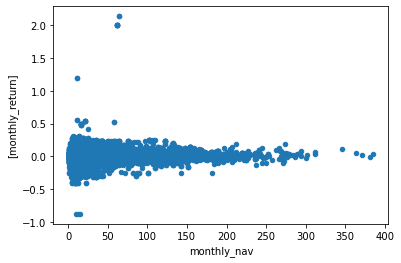

In [190]:
# Useless plot when looked at aggregate
monthly_return_nav[['monthly_nav','monthly_return']].plot(kind='scatter',  x = 'monthly_nav', y = ['monthly_return'])

In [191]:
# Return according to fund size
monthly_return_fund_size = monthly_return_nav[['caldt','fund_size','monthly_return']].groupby(by = ['caldt','fund_size']).mean()
monthly_return_fund_size = monthly_return_fund_size.unstack()

In [192]:
monthly_return_fund_sizev2 = monthly_return_fund_size.dropna()
monthly_return_fund_sizev2 = monthly_return_fund_sizev2['monthly_return']
monthly_return_fund_sizev2.head()

fund_size,large,medium,small
caldt,,,
1983-09-30,0.034307,0.027460,-0.018349
1985-03-29,-0.006625,-0.020198,-0.015573
1985-04-30,-0.000505,-0.023401,-0.011008
1985-07-31,0.036234,0.027692,0.006660
1985-08-30,-0.009251,-0.011228,-0.004733


In [193]:
# Average monthly return
monthly_return_fund_sizev2.mean()

fund_size
large     0.010801
medium    0.009663
small     0.008352
dtype: float64

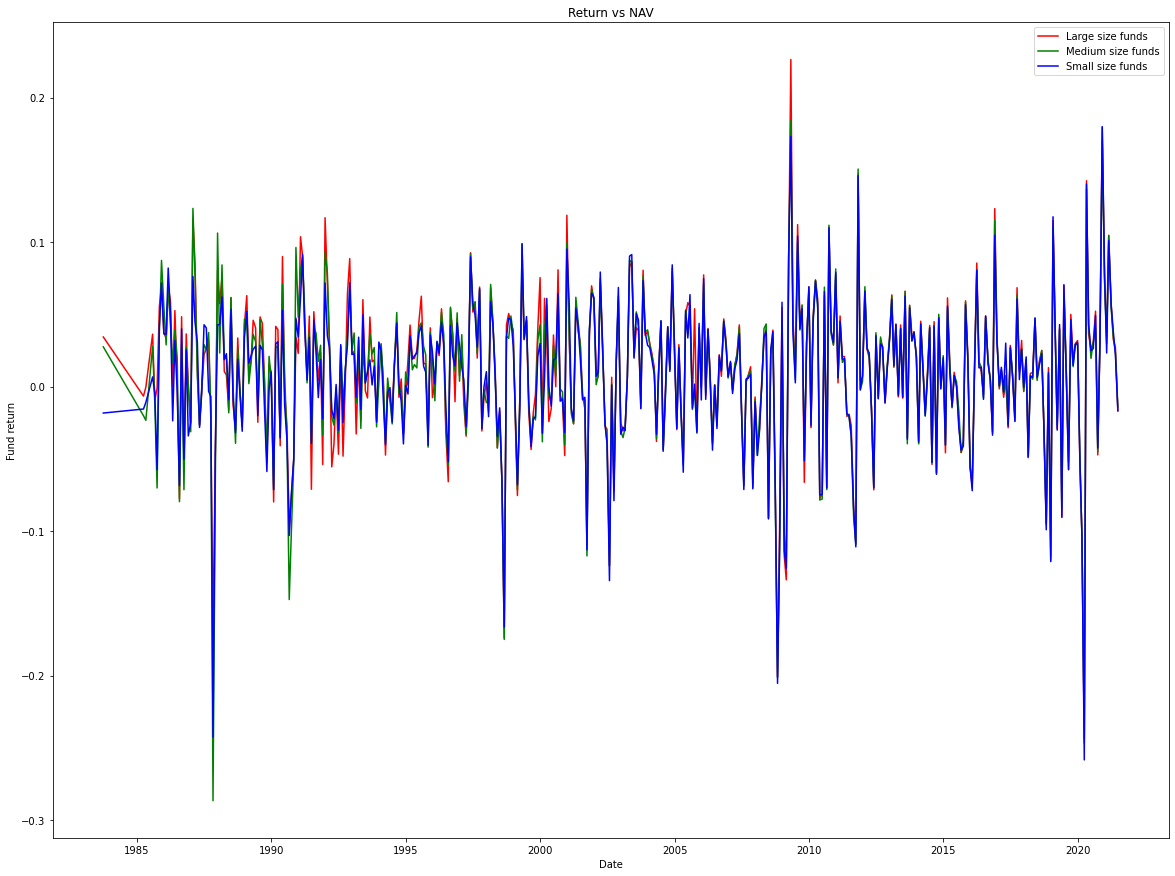

In [194]:
## plotting daily returns
fig, ax1 = plt.subplots(figsize=(20,15))
plt.title('Return vs NAV')
monthly_return_fund_sizev2['large'] .plot(kind='line', marker=None, color ='r', label = 'Large size funds')
monthly_return_fund_sizev2['medium'] .plot(kind='line', marker=None, color ='g', label = 'Medium size funds')
monthly_return_fund_sizev2['small'] .plot(kind='line', marker=None, color ='b', label = 'Small size funds')
plt.xlabel('Date')
plt.ylabel('Fund return')
plt.legend()
plt.show()

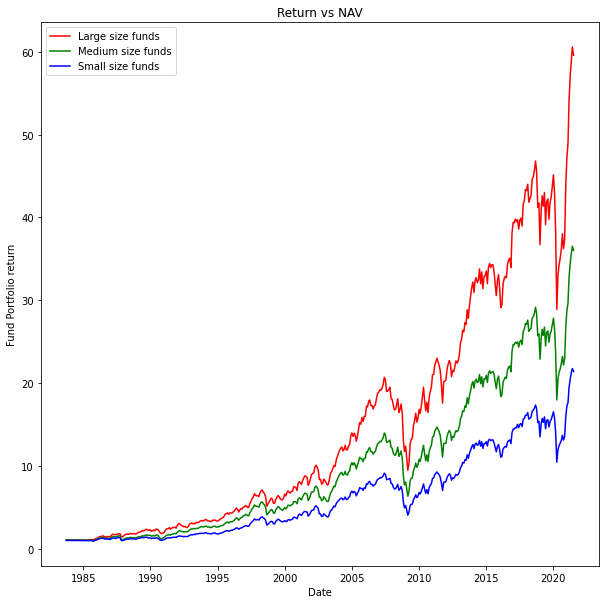

In [216]:
## Portfolio Return from 1980
monthly_return_fund_size_returns = pd.DataFrame()
monthly_return_fund_size_returns['large'] = 1+ monthly_return_fund_sizev2['large']
monthly_return_fund_size_returns['medium'] = 1+ monthly_return_fund_sizev2['medium']
monthly_return_fund_size_returns['small'] = 1+ monthly_return_fund_sizev2['small']

monthly_return_fund_size_returns = monthly_return_fund_size_returns.cumprod()

## plotting average portfolio returns
fig, ax1 = plt.subplots(figsize=(10,10))
plt.title('Return vs NAV')
monthly_return_fund_size_returns['large'] .plot(kind='line', marker=None, color ='r', label = 'Large size funds')
monthly_return_fund_size_returns['medium'] .plot(kind='line', marker=None, color ='g', label = 'Medium size funds')
monthly_return_fund_size_returns['small'] .plot(kind='line', marker=None, color ='b', label = 'Small size funds')
plt.xlabel('Date')
plt.ylabel('Fund Portfolio return')
plt.legend()
plt.show()

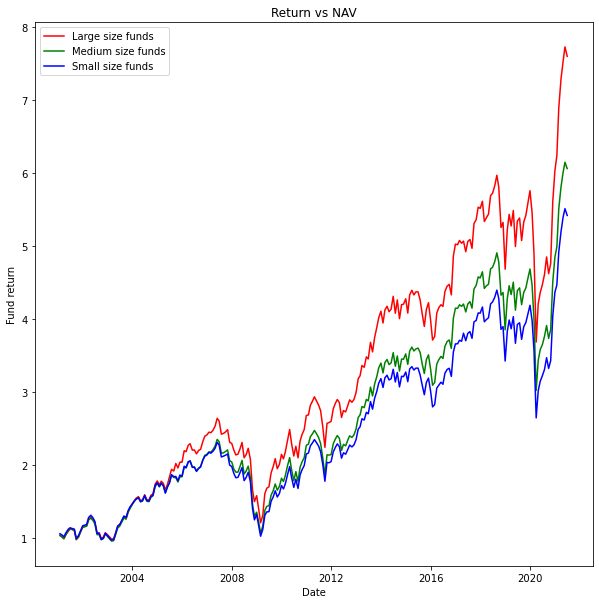

In [214]:
## Portfolio Return from 2000
monthly_return_fund_sizev3 = monthly_return_fund_sizev2[DatetimeIndex(monthly_return_fund_sizev2.index).year > 2000]

monthly_return_fund_size_returns = pd.DataFrame()
monthly_return_fund_size_returns['large'] = 1+ monthly_return_fund_sizev3['large']
monthly_return_fund_size_returns['medium'] = 1+ monthly_return_fund_sizev3['medium']
monthly_return_fund_size_returns['small'] = 1+ monthly_return_fund_sizev3['small']

monthly_return_fund_size_returns = monthly_return_fund_size_returns.cumprod()

## plotting average portfolio returns
fig, ax1 = plt.subplots(figsize=(10,10))
plt.title('Return vs NAV')
monthly_return_fund_size_returns['large'] .plot(kind='line', marker=None, color ='r', label = 'Large size funds')
monthly_return_fund_size_returns['medium'] .plot(kind='line', marker=None, color ='g', label = 'Medium size funds')
monthly_return_fund_size_returns['small'] .plot(kind='line', marker=None, color ='b', label = 'Small size funds')
plt.xlabel('Date')
plt.ylabel('Fund return')
plt.legend()
plt.show()

In [243]:
### Part 2 

# monthly_returns - returns
# mnav - monthly totalnetasset

df = db.raw_sql("""
select lipper_obj_name, lipper_class_name, avg(exp_ratio) average_exp_ratio,
avg(mgmt_fee) average_mgmt_fee
from crsp.fund_summary2
where caldt > '12/01/2020'
and lipper_obj_name = 'SMALL-CAP FUNDS' and lipper_class_name like '%Small-Cap%'
group by lipper_class_name,lipper_obj_name 

                        """, 
date_cols=['date'])

df

,lipper_obj_name,lipper_class_name,average_exp_ratio,average_mgmt_fee
0,SMALL-CAP FUNDS,Small-Cap Core Funds,0.010254,0.473154
1,SMALL-CAP FUNDS,Small-Cap Growth Funds,0.012257,0.718435
2,SMALL-CAP FUNDS,Small-Cap Value Funds,0.011719,0.583373


In [248]:
check = db.raw_sql("""

select fund_size, avg(mgmt_fee) mgmt_fee, avg(exp_ratio) exp_ratio from (
select *,
case when monthly_nav <=13 then 'small'
when monthly_nav >= 20 then 'large'
when monthly_nav between 13 and 20 then 'medium' end fund_size
from (
select a.*, b.caldt, b.mret monthly_return, c.mnav monthly_nav  from (
select distinct crsp_fundno, fund_name, lipper_class_name,exp_ratio, mgmt_fee
from crsp.fund_summary2
where lipper_obj_name = 'SMALL-CAP FUNDS' and lipper_class_name = 'Small-Cap Value Funds')a
inner join crsp.monthly_returns b on a.crsp_fundno = b.crsp_fundno 
inner join crsp.monthly_tna_ret_nav c on b.crsp_fundno = c.crsp_fundno and b.caldt = c.caldt) x)y
where fund_size in ('large','medium','small')
group by fund_size
                        
                        """, 
                     date_cols=['date'])

check.head()

,fund_size,mgmt_fee,exp_ratio
0,large,0.506732,0.012907
1,medium,0.508526,0.014000
2,small,0.394319,0.014625
